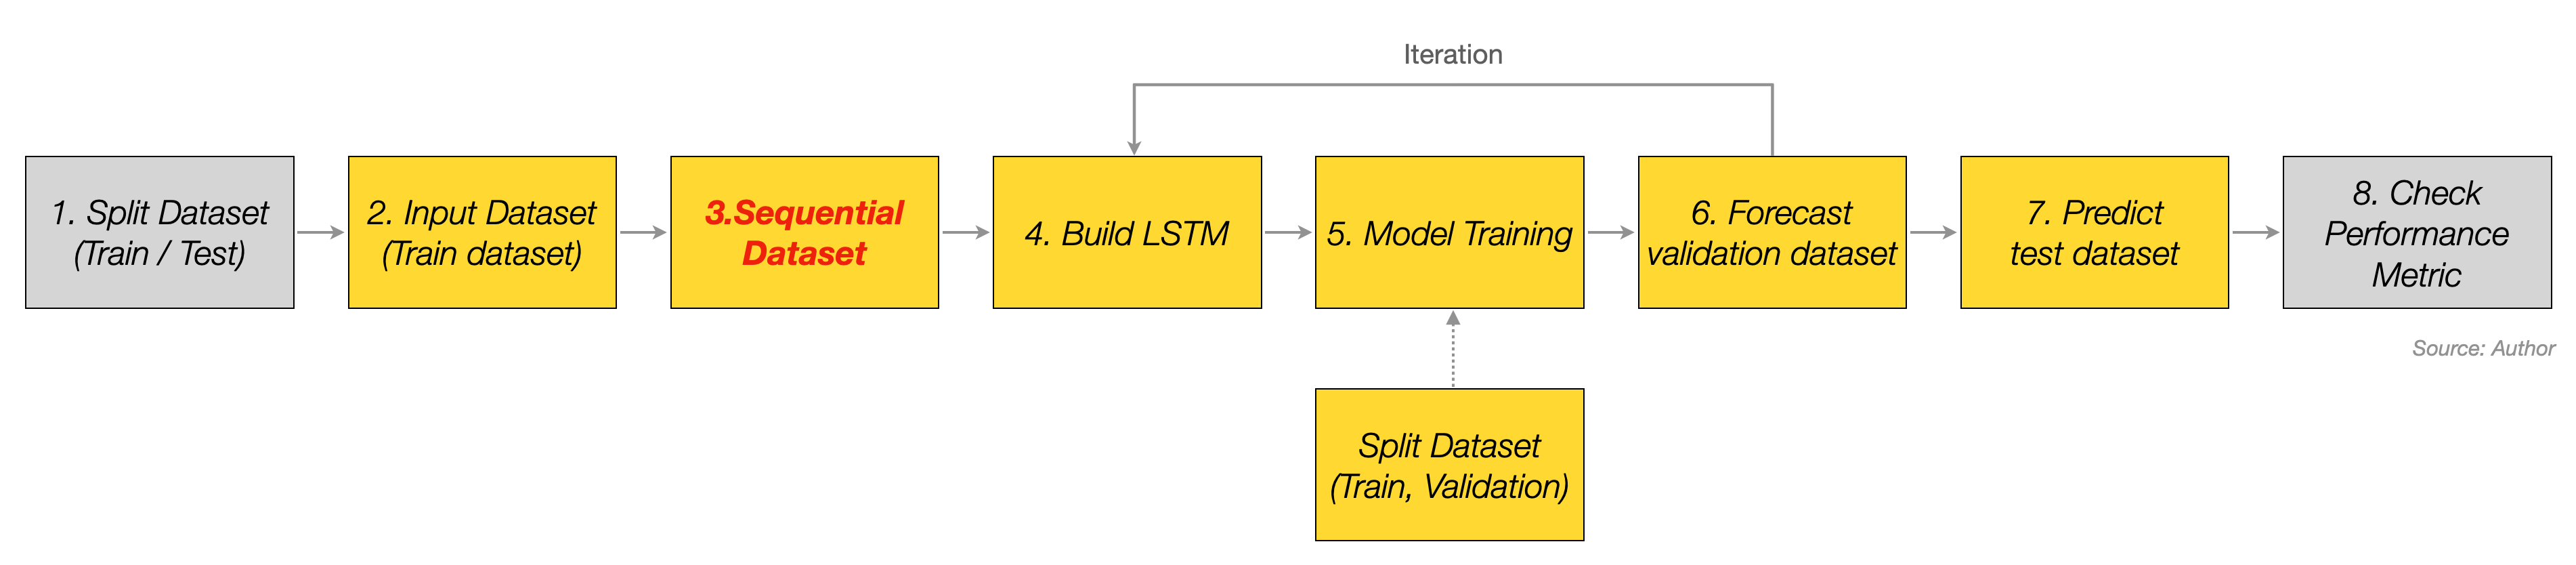

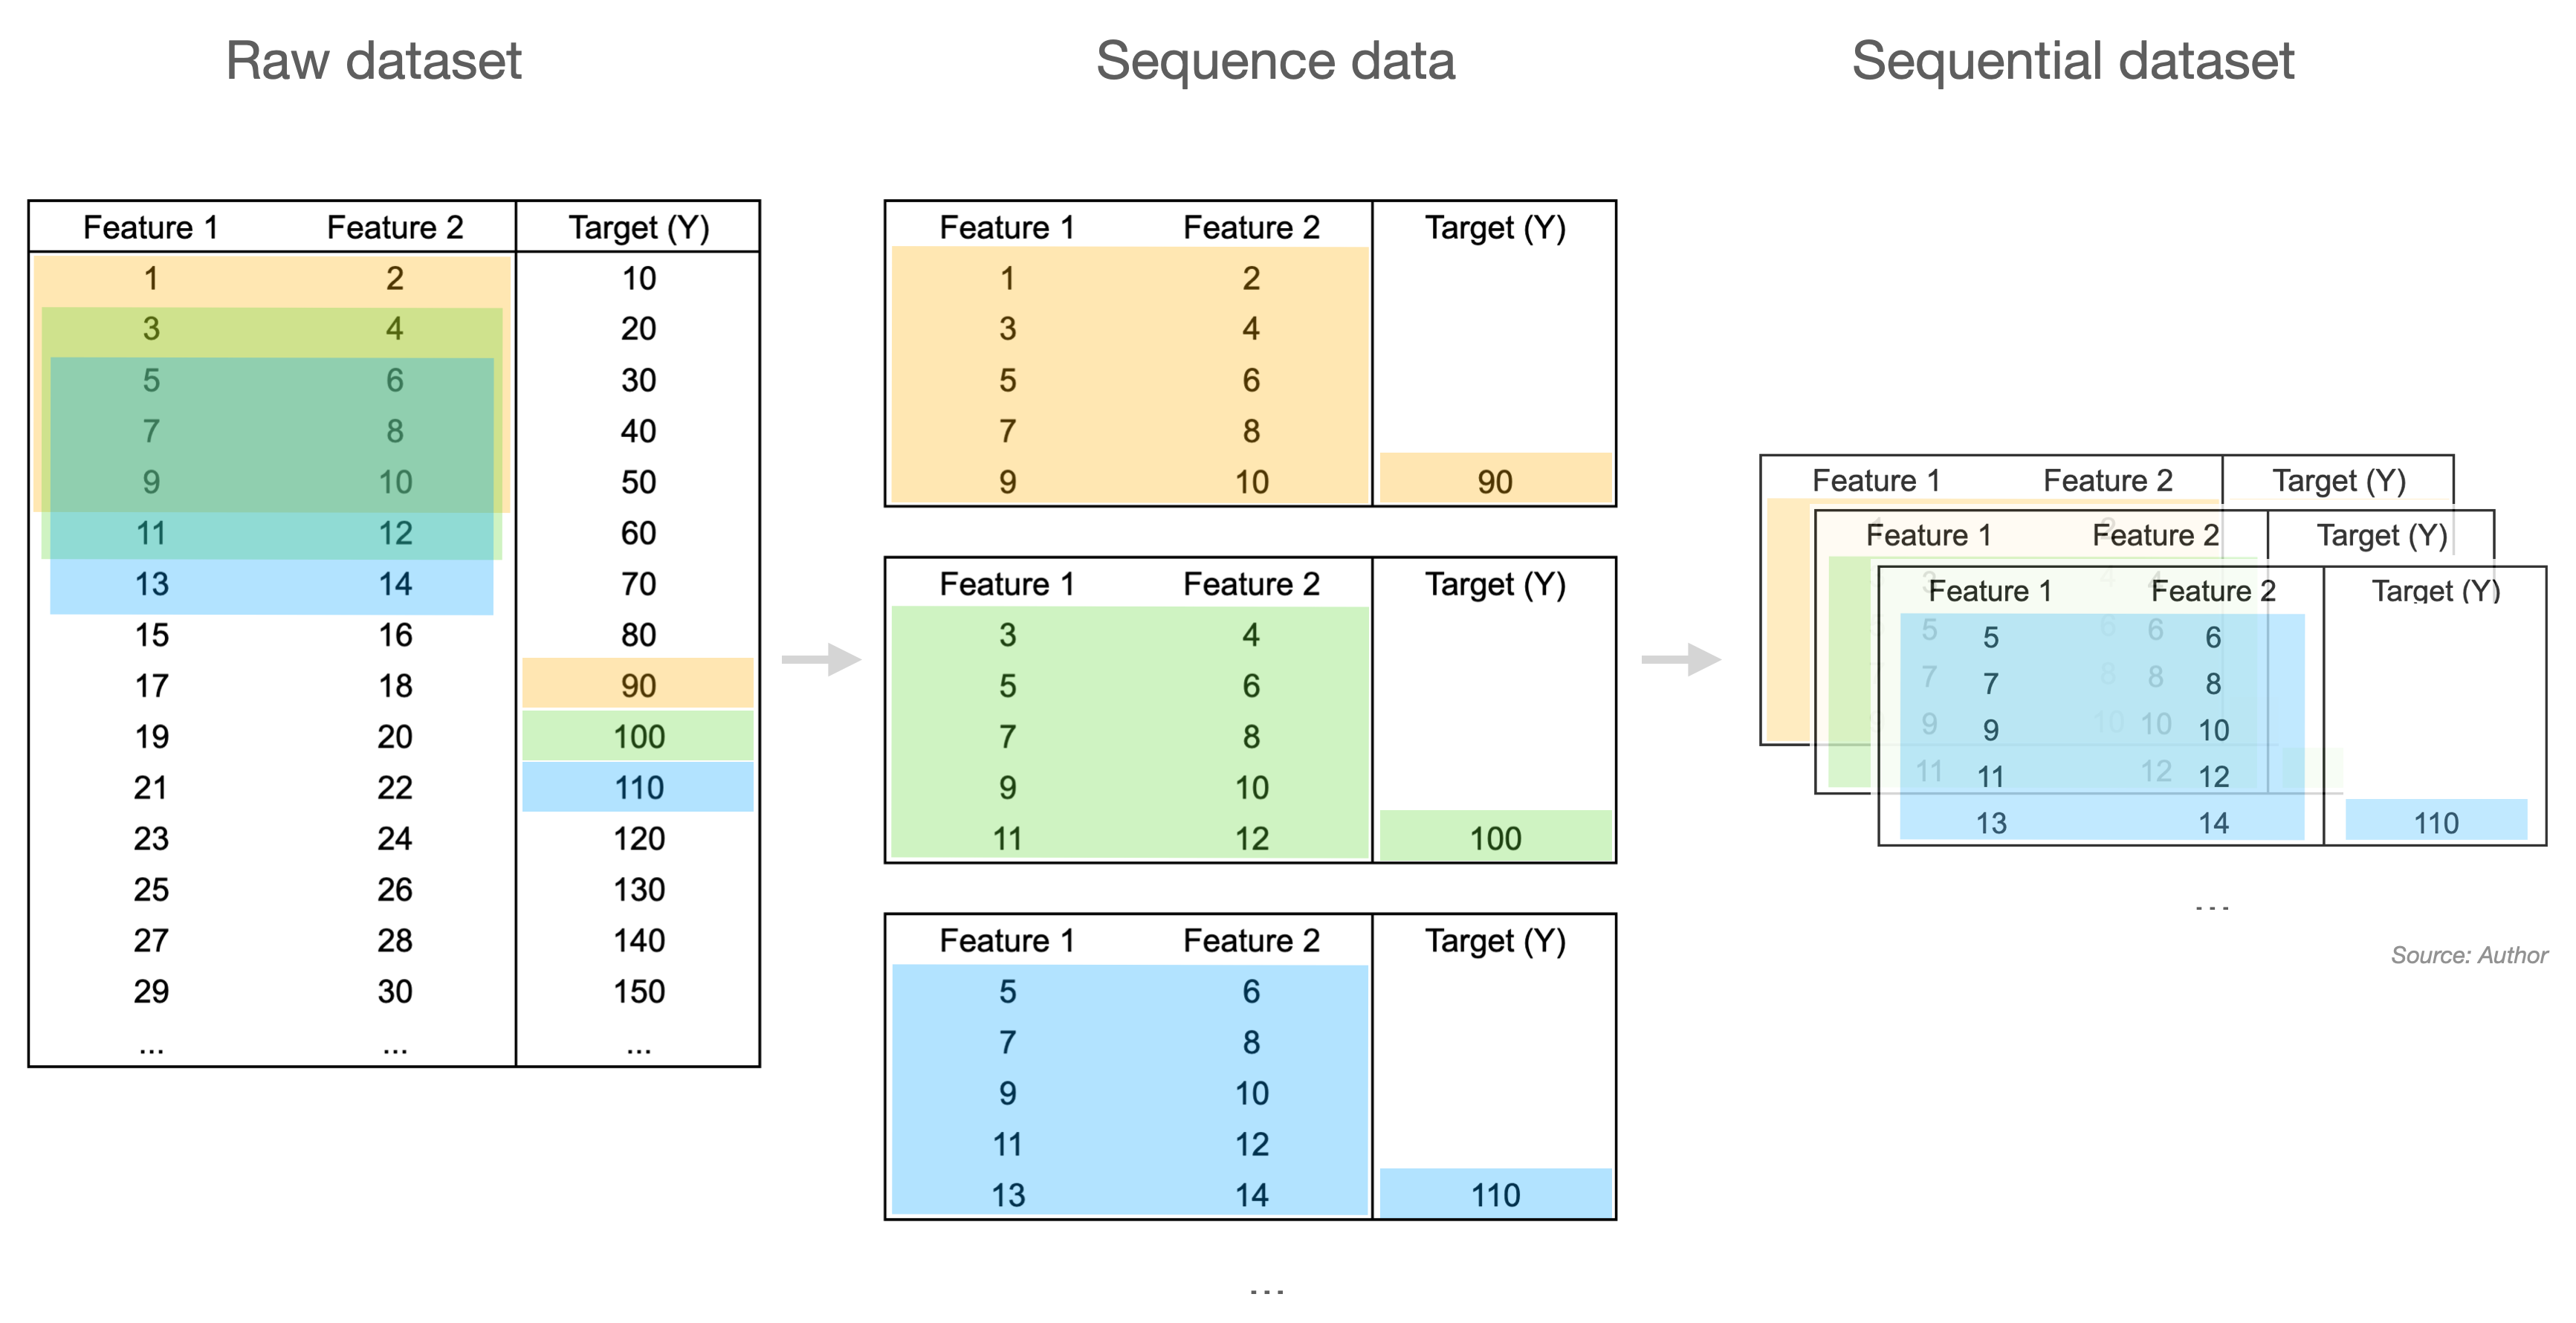

In [41]:
import random
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm  # 진행 상황을 시각화하여 보여주는 라이브러리
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn  # PyTorch의 신경망 관련 모듈
import torch.optim as optim  # optimizer 모듈
import torch.nn.functional as F  # 함수형 API를 사용하기 위한 모듈
from torch.utils.data import Dataset, DataLoader  #  PyTorch의 데이터셋 및 데이터로더를 관리하는 클래스

### 옵티마이저(Optimizer) 모듈
- 머신 러닝 모델의 학습 과정에서 사용되는 알고리즘을 구현한 라이브러리나 클래스입니다. 이 모듈은 모델의 가중치(파라미터)를 업데이트하는 데 사용되며, 주어진 손실 함수를 최소화하는 방향으로 모델을 향해 조정합니다. 옵티마이저는 학습 속도 및 안정성을 향상시키기 위한 여러 전략과 알고리즘을 제공합니다.

1. **SGD (Stochastic Gradient Descent)**: 확률적 경사 하강법은 간단한 옵티마이저로, 매 반복마다 랜덤한 데이터 포인트나 미니 배치를 사용하여 가중치를 업데이트합니다. 빠른 수렴이 가능하지만 불안정한 경향이 있을 수 있습니다.

2. **Adam (Adaptive Moment Estimation)**: Adam은 모멘텀과 학습률 조정을 결합한 옵티마이저로, 적응적인 학습률 조정과 지수 이동 평균을 사용하여 효과적으로 학습합니다. 주로 딥러닝에서 널리 사용됩니다.

3. **RMSprop (Root Mean Square Propagation)**: RMSprop은 학습률을 적응적으로 조정하는 Adam과 비슷한 옵티마이저로, 지수 이동 평균을 사용하여 가중치를 업데이트합니다.

4. **Adagrad (Adaptive Gradient Algorithm)**: Adagrad는 학습률을 특성별로 적응적으로 조정하여 학습하는 옵티마이저입니다. 이전에 적은 빈도로 업데이트된 특성의 학습률을 증가시켜 더 자주 업데이트됩니다.

5. **AdaDelta**: Adagrad의 단점을 보완한 옵티마이저로, 특성의 학습률을 누적 합을 사용하여 적응적으로 조정합니다.

6. **AdamW**: Weight decay(가중치 감쇠)를 Adam 옵티마이저와 결합한 버전으로, 모델의 과적합을 방지하는 데 도움을 줍니다.

즉, 옵티마이저는 학습 과정에서 모델이 손실 함수를 효과적으로 최소화하고 최적의 가중치를 찾을 수 있도록 도와줍니다.

In [42]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Hyperparameter Setting

In [43]:
CFG = {
    'TRAIN_WINDOW_SIZE':90, # 90일치로 학습
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':4096,
    'SEED':41
}

In [44]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

설정 구성 및 재현성을 위한 랜덤 시드를 설정

## 1. CFG 사전:
   이 사전에는 머신 러닝 모델 또는 훈련 프로세스에 대한 다양한 구성 매개변수가 포함되어 있습니다. 매개변수는 다음과 같습니다:
   - `TRAIN_WINDOW_SIZE`: 훈련 창 크기 (이 경우 90일).
   - `PREDICT_SIZE`: 예측할 날짜 수 (이 경우 21일).
   - `EPOCHS`: 훈련 에포크 수 (이 경우 10 에포크).
   - `LEARNING_RATE`: 옵티마이저의 학습률 (이 경우 1e-4).
   - `BATCH_SIZE`: 훈련용 배치 크기 (이 경우 4096).
   - `SEED`: 재현성을 위한 랜덤 시드 (시드 값은 41).

## 2. seed_everything  함수:
   이 함수는 다양한 라이브러리 및 훈련 프로세스의 구성 요소 전체에 걸쳐 랜덤 시드를 설정하여 결과의 재현성을 보장하기 위해 정의됩니다. `seed` 매개변수를 입력으로 받고 다음과 같은 항목에 대한 랜덤 시드를 설정합니다:
   - 파이썬의 내장 `random` 모듈.
   - `PYTHONHASHSEED` 환경 변수를 시드의 문자열 표현으로 설정.
       - 파이썬 내장 해시 함수에 사용되는 시드 값을 설정하는 환경 변수. 이 값을 설정하면 해시 함수가 동일한 입력에 대해 동일한 결과를 생성하도록 할 수 있습니다. 이는 프로그램 실행 시마다 동일한 해시 값이 생성되어 예측 가능성과 재현성을 제공하는 데 사용됩니다.
       - 해시 함수(Hash Function)는 임의의 크기의 데이터를 고정된 크기의 값으로 매핑하는 함수
   - NumPy 라이브러리의 랜덤 숫자 생성기.
   - PyTorch의 CPU용 랜덤 숫자 생성기.
   - PyTorch의 GPU(CUDA)용 랜덤 숫자 생성기.
   - PyTorch의 CuDNN (CUDA Deep Neural Network 라이브러리) 설정을 통해 결정론적인 동작 보장.
   - PyTorch의 CuDNN 벤치마킹 모드를 활성화하여 훈련 속도 향상.

3. `seed_everything(CFG['SEED'])`:
   이 코드 줄은 `CFG` 사전에 지정된 시드 값 (`41`)으로 `seed_everything` 함수를 호출합니다. 이 단계는 다양한 라이브러리 간의 랜덤 숫자 생성기가 동일한 시드로 초기화되어 코드의 결과를 재현 가능하게 합니다.

종합적으로, 이 코드 스니펫은 머신 러닝 프로젝트에서 설정 구성 및 랜덤 시드를 설정하는 데 사용되는 모범 사례입니다. 특히 확률적인 데이터나 확률적인 구성 요소를 가진 모델을 훈련할 때 훈련 중에 도입되는 무작위성을 제어하는 데 사용됩니다.

### 옵티마이저의 학습률(LEARNING_RATE)
- 머신 러닝 모델의 훈련 과정에서 사용되는 하이퍼파라미터 중 하나입니다. 학습률은 모델이 각 반복(에포크)에서 가중치를 조정하는 양을 결정합니다. 즉, 학습률은 가중치 업데이트의 크기를 제어하여 모델이 수렴하는 속도와 안정성을 조절하는 역할을 합니다.

- 일반적으로 학습률은 0.1, 0.01, 0.001과 같은 작은 값들이 사용되며, 1e-4는 0.0001과 같은 의미입니다. **작은 학습률은 모델의 가중치를 더 조심스럽게 업데이트하므로 더 많은 반복을 통해 수렴할 가능성이 높아지지만, 너무 작으면 학습 속도가 느려질 수 있습니다. 반면에 큰 학습률은 빠르게 수렴할 수 있지만, 최적값을 지나쳐서 발산할 가능성이 있습니다.**

- 따라서 옵티마이저의 학습률은 조정이 필요한 중요한 하이퍼파라미터이며, 실험을 통해 데이터와 모델에 맞는 적절한 학습률을 찾는 것이 중요합니다. 주어진 코드에서 `LEARNING_RATE` 값은 1e-4로 설정되어 있습니다. 이 값은 학습률이 상대적으로 작은 값을 가지도록 설정되었음을 나타냅니다.

### 랜덤 시드(Random Seed)
- 컴퓨터 프로그램 내에서 생성되는 난수(랜덤한 숫자)의 시퀀스를 시작하는 초기값을 말합니다. 난수는 프로그램 실행 중에 무작위성을 도입하기 위해 사용되며, 많은 컴퓨터 과학 및 머신 러닝 작업에서 중요한 역할을 합니다. 랜덤 시드는 이러한 난수 생성을 제어하고 예측 가능한 결과를 얻기 위해 사용됩니다.

- 랜덤 시드의 중요성과 필요성

1. **재현성 보장**: 프로그램이나 실험의 결과를 재현할 수 있는 능력은 연구나 개발 과정에서 중요합니다. 같은 코드와 매개변수를 사용하더라도 랜덤성이 도입되면 결과가 다를 수 있습니다. 랜덤 시드를 사용하면 특정 시드 값을 고정하여 동일한 초기 조건에서 일관된 결과를 얻을 수 있습니다.

2. **디버깅 및 테스트**: 랜덤성이 포함된 코드를 디버깅하거나 테스트하는 경우, 랜덤 시드를 설정하여 문제를 추적하고 해결하는 데 도움이 됩니다. **동일한 랜덤 시드를 사용하면 특정 문제 상황을 재현하고 분석할 수 있습니다.**

3. **모델 비교 및 성능 평가**: 다양한 모델을 비교하거나 다른 하이퍼파라미터를 사용하여 실험을 진행할 때, 랜덤 시드를 제어하여 정확한 성능 비교를 수행할 수 있습니다. 모든 실험에서 동일한 시작 상태를 유지하면 모델 간 성능 차이를 정확하게 평가할 수 있습니다.

4. **데이터 분할 및 훈련**: 데이터를 무작위로 분할하거나 모델을 초기화할 때 랜덤성을 사용할 수 있습니다. 랜덤 시드를 설정하면 동일한 데이터 분할이나 모델 초기화를 유지하면서 실험을 진행할 수 있습니다.

5. **노이즈 추가 및 데이터 증강**: 데이터에 노이즈를 추가하거나 데이터 증강을 수행할 때도 랜덤성이 활용됩니다. 랜덤 시드를 사용하여 동일한 노이즈 또는 증강을 적용하면 일관된 실험을 수행할 수 있습니다.

랜덤 시드는 결과의 예측 가능성과 실험의 일관성을 확보하기 위해 매우 중요한 개념입니다. 특히 머신 러닝과 통계 분야에서는 랜덤 시드를 제어하여 결과의 신뢰성을 높이고 비교 가능한 실험을 수행하는 데 도움이 됩니다.

In [16]:
train_data_origin = pd.read_csv('./train.csv').drop(columns=['ID', '제품'])

# 데이터 전처리
-  Min-Max Scaling 사용하여 정규화(normalization) : 데이터의 최솟값을 0, 최댓값을 1로 설정하고, 나머지 데이터는 이 사이의 값으로 변환

In [7]:
# Data Scaling
scale_max_dict = {}
scale_min_dict = {}

for idx in tqdm(range(len(train_data))):
    maxi = np.max(train_data.iloc[idx,4:])
    mini = np.min(train_data.iloc[idx,4:])
    
    if maxi == mini :
        train_data.iloc[idx,4:] = 0
    else:
        train_data.iloc[idx,4:] = (train_data.iloc[idx,4:] - mini) / (maxi - mini)
    
    scale_max_dict[idx] = maxi
    scale_min_dict[idx] = mini

  0%|          | 0/15890 [00:00<?, ?it/s]

전처리 과정의 Scaling 작업이 시간이 오래 소요돼서, 간소화 

In [45]:
# 숫자형 변수들의 min-max scaling을 수행하는 코드입니다.
numeric_cols = train_data_origin.columns[4:]
# 칵 column의 min 및 max 계산
min_values = train_data_origin[numeric_cols].min(axis=1)   # axis=1 : col
max_values = train_data_origin[numeric_cols].max(axis=1)
# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 1로 대체 (분모 0되는 것 방지)
ranges = max_values - min_values
ranges[ranges == 0] = 1
# min-max scaling 수행
train_data_origin[numeric_cols] = (train_data_origin[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)
# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()

In [46]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

## 범주형 변수를 레이블 인코딩(Label Encoding)하여 수치형으로 변환하는 작업을 수행

1. **`LabelEncoder` 초기화**:
   `LabelEncoder` 클래스를 초기화하여 `label_encoder` 변수에 저장합니다. 이 레이블 인코더는 범주형 변수를 수치형으로 변환하는데 사용됩니다.

2. **범주형 변수 선택**:
   `categorical_columns`에는 레이블 인코딩을 수행할 대상이 되는 범주형 변수들의 열 이름이 리스트로 저장되어 있습니다.

3. **루프를 통한 레이블 인코딩 수행**:
   `categorical_columns` 리스트의 각 열 이름에 대해 반복문을 실행합니다. 각 열에 대해 다음 작업을 수행합니다.
   
   - `label_encoder.fit(train_data[col])`: 현재 열에 있는 고유한 범주들을 학습합니다. 즉, 각 범주에 고유한 수치 값을 할당하는 인코딩 방식을 학습합니다.
   
   - `label_encoder.transform(train_data[col])`: 학습된 인코딩 방식에 따라 현재 열의 각 범주를 수치 값으로 변환합니다. 이렇게 함으로써 범주형 변수가 수치형으로 변환됩니다.
   
   - `train_data[col] = label_encoder.transform(train_data[col])`: 현재 열의 원래 범주 값을 해당 인코딩된 수치 값으로 대체합니다. 이를 통해 데이터프레임의 해당 열이 레이블 인코딩된 형태로 변경됩니다.

결과적으로, 주어진 코드는 `categorical_columns`에 나열된 열들에 대해 레이블 인코딩을 수행하여 범주형 변수를 수치형 변수로 변환합니다. 레이블 인코딩은 일반적으로 트리 기반 모델 등에서 범주형 변수를 처리할 때 사용됩니다.

In [38]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    #               data: 일별 판매량, train_size: 학습에 사용할 기간, predict_size: 추론할 기간
    
    num_rows = len(data)  # 데이터의 행 개수 (일 수)
    window_size = train_size + predict_size  # 학습과 예측에 사용할 전체 기간 크기
    
    # 입력 데이터 배열과 타겟 데이터 배열 초기화
    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :4]) + 1))
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size))
    
    # 데이터 생성 루프
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])  # 분류 정보
        sales_data = np.array(data.iloc[i, 4:])  # 판매량 데이터
        
        for j in range(len(sales_data) - window_size + 1): # 예측기간
            window = sales_data[j : j + window_size]  # 현재 윈도우~ 윈도우 사이즈의 판매량 데이터
            
            # 입력 데이터 생성
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            
            # 타겟 데이터 생성
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]
    
    return input_data, target_data

## make_train_data는 시계열 데이터를 기반으로 학습 데이터와 예측 데이터를 생성
- `window_size`: 학습과 예측에 사용할 기간의 크기로, 학습 기간과 예측 기간을 합한 값입니다.

- `input_data`: 학습 데이터로 사용될 입력 데이터를 저장할 배열입니다. 배열의 형태는 `(데이터포인트개수, 학습기간, 피처개수)`입니다.

- `target_data`: 예측 대상 데이터(타겟 데이터)를 저장할 배열입니다. 배열의 형태는 `(데이터포인트개수, 예측기간)`입니다.


1. `encode_info`와 `sales_data` 초기화:
   각 데이터 포인트마다 대분류, 중분류, 소분류, 브랜드 정보를 `encode_info`로 저장하고, 판매량 데이터를 `sales_data`로 저장합니다.

2. `for` 루프:
   데이터 포인트마다 반복문을 실행하여 데이터 생성 작업을 수행합니다.

   - `window` 변수는 현재 위치에서부터 `window_size`까지의 판매량 데이터를 저장합니다.

   - **입력 데이터 생성** : `encode_info`와 `window[:train_size]`를 결합하여 현재 윈도우의 학습 데이터를 생성합니다. `np.tile(encode_info, (train_size, 1))`는 분류 정보를 학습 기간만큼 반복하는 역할을 합니다. 
    - *배열의 크기는 `(데이터포인트개수 * 윈도우개수, 학습기간, 분류정보개수 + 1)`*
    - **입력 데이터 생성 (`temp_data`)**: 분류 정보와 학습 기간 내의 판매량 데이터로 구성

       - `np.tile(encode_info, (train_size, 1))`: `encode_info`는 대분류, 중분류, 소분류, 브랜드 정보를 가지고 있습니다. 이 정보를 학습 기간만큼 반복하여 모든 학습 기간에 대해 동일한 분류 정보를 가지도록 합니다. 

       - `window[:train_size]`: `window` 배열에서 처음부터 학습 기간 크기까지의 판매량 데이터를 선택합니다.

       - `np.column_stack(...)`: 위에서 생성한 두 배열을 열 방향으로 합쳐서 `temp_data`를 생성합니다. 

       - `input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data`: `input_data` 배열의 특정 위치에 `temp_data`를 저장합니다. 이 위치 계산은 데이터 포인트 및 윈도우 인덱스에 따라 합니다.



   - 타겟 데이터 생성: `window[train_size:]`는 예측 기간에 해당하는 판매량 데이터를 타겟 데이터로 저장합니다. 
   - *`(데이터포인트개수 * 윈도우개수, 예측기간)`*

- `i * (len(data.columns) - window_size + 1) + j`:
   - `i`: 현재 데이터 포인트의 인덱스입니다.
   - `j`: 현재 데이터 포인트의 판매량 데이터 내에서의 윈도우 위치 인덱스입니다.
   - `len(data.columns) - window_size + 1`: 각 데이터 포인트에서 가능한 윈도우의 개수입니다. 각 데이터 포인트에 대해 여러 윈도우를 만들 수 있기 때문에 계산에 포함됩니다.

위의 계산은 예측 대상인 `target_data` 배열 내에서 각 예측 시점에 대한 위치를 계산합니다. 따라서 해당 위치에 해당하는 판매량 데이터를 저장합니다. 이렇게 함으로써 시계열 데이터의 각 데이터 포인트에 대한 여러 예측 시점의 타겟 데이터가 생성됩니다.

`np.tile(encode_info, (train_size, 1))`은 주어진 배열인 `encode_info`를 특정 방향으로 반복하여 새로운 배열을 생성하는 함수입니다. 

예를 들어, `encode_info`가 `[1, 2, 3, 4]`라고 가정하겠습니다. 이 배열은 대분류, 중분류, 소분류, 브랜드 정보로 이루어져 있다고 가정합니다.

1. **반복 횟수 지정**:
   `np.tile(encode_info, (train_size, 1))`에서 `(train_size, 1)`은 반복 횟수를 지정하는 튜플입니다. 첫 번째 값 `train_size`는 행 방향으로 배열을 몇 번 반복할지를 지정합니다. 두 번째 값 `1`은 열 방향으로 배열을 몇 번 반복할지를 지정합니다.

2. **반복 방향**:
   `(train_size, 1)`에서 첫 번째 값인 `train_size`만큼 행 방향으로 배열을 반복하고, 두 번째 값인 `1`은 열 방향으로는 반복하지 않음을 의미합니다. 즉, 결과 배열의 열 수는 원래 배열과 동일하게 유지됩니다.

3. **반복된 배열 생성**:
   위 설정에 따라 `encode_info` 배열이 `train_size` 행으로 반복되며, 열은 그대로 유지됩니다. 결과적으로 (train_size, 4) 크기의 배열이 생성됩니다. 각 행은 `encode_info` 배열의 내용을 가지고 있습니다.

예를 들어, `encode_info`가 `[1, 2, 3, 4]`이고 `train_size`가 3인 경우 결과 배열은 다음과 같이 됩니다:

```
[[1, 2, 3, 4],
 [1, 2, 3, 4],
 [1, 2, 3, 4]]
```
**즉, `encode_info` 배열의 정보를 학습 기간만큼 반복하여 모든 학습 기간에 대해 동일한 분류 정보를 가지도록 만드는 역할을 합니다.**

baseline의 make_train_data 함수에서는 1씩 sliding 하며 데이터셋을 만듭니다.
그 결과로 500만개 이상의 데이터가 만들어지는데, 데이터셋의 크기가 커서
코드를 실행하는 환경의 RAM 용량이 받쳐주지 않는다면 코드가 멈추게 됩니다.

제 방법은 sliding 할 때, for문의 step size를 2 또는 그 이상으로 변경하여
데이터셋의 크기를 줄여 제한된 환경에서 학습이 가능하도록 하는 방법입니다.

아래 코드에서 STEP_SIZE 값을 본인의 환경에 맞게 조정하시면 됩니다.

In [47]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    STEP_SIZE = 10 # 이 값을 본인의 환경에 맞게 조정
    
    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :4]) + 1))
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, 4:])

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * adjusted_size + j // STEP_SIZE] = temp_data
            target_data[i * adjusted_size + j // STEP_SIZE] = window[train_size:]

    return input_data, target_data

- STEP_SIZE: 데이터 생성 루프에서 윈도우를 얼마씩 이동시킬지를 결정하는 변수입니다. 이 값을 조정하여 데이터 포인트 간 간격을 조절할 수 있습니다.

- adjusted_size: 데이터 포인트마다 생성되는 윈도우의 개수입니다. STEP_SIZE를 고려하여 계산됩니다.

- 데이터 생성 루프는 STEP_SIZE 간격으로 데이터를 생성합니다. 이로 인해 데이터 포인트 간 겹치는 부분이 줄어들게 됩니다.

## 평가 데이터에 대한 입력 데이터를 생성

In [48]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)
    
    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :4]) + 1))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, -train_size:])
        
        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data
    
    return input_data

`-train_size:`가 사용된 부분은 시계열 데이터에서 특정 기간의 데이터를 추출하는 과정을 의미합니다. 이 부분이 왜 `-train_size:`로 사용되는지 설명해드리겠습니다.

시계열 데이터에서는 과거 데이터를 활용하여 모델을 학습하고 미래를 예측하는 경우가 많습니다. 학습에 사용되는 데이터의 기간을 제한하기 위해 '윈도우'를 설정하는데, 이 윈도우의 크기를 `train_size`로 지정하고 있습니다. 즉, 과거 데이터의 `train_size`만큼을 활용하여 모델을 학습하고, 그 후에 미래 데이터를 예측하는 것을 목표로 합니다.

여기서 `-train_size:`는 인덱싱 연산을 통해 '마지막부터 train_size만큼 이전까지'의 데이터를 추출하겠다는 의미입니다. 데이터의 시간적 흐름을 고려할 때, 마지막 데이터가 가장 최근 데이터이고 거기서부터 과거로 이동하면서 `train_size`만큼의 데이터를 추출하게 됩니다. 

이러한 방식으로 설정하는 이유는 모델을 학습할 때 최근의 데이터를 더 중요하게 고려하고자 하는 것입니다. 이로써 모델은 보다 최신의 패턴과 동향을 파악하여 더 정확한 예측을 수행할 수 있게 됩니다.

In [49]:
train_input, train_target = make_train_data(train_data)
test_input = make_predict_data(train_data)

  0%|          | 0/15890 [00:00<?, ?it/s]

  0%|          | 0/15890 [00:00<?, ?it/s]

In [58]:
# Train / Validation(검증) Split
data_len = len(train_input)
val_input = train_input[-int(data_len*0.2):]
val_target = train_target[-int(data_len*0.2):]
train_input = train_input[:-int(data_len*0.2)]
train_target = train_target[:-int(data_len*0.2)]

In [51]:
train_input.shape, train_target.shape, val_input.shape, val_target.shape, test_input.shape

((444920, 90, 5), (444920, 21), (111230, 90, 5), (111230, 21), (15890, 90, 5))

# Custom Dataset

### `CustomDataset` 클래스는 PyTorch의 `Dataset` 클래스를 상속하여 만들어진 사용자 정의 데이터셋
- 이 클래스를 활용하면 데이터를 미니배치로 나누고 데이터 로더(DataLoader)를 생성하여 모델 학습 시 사용할 수 있습니다. 데이터 로더를 사용하면 데이터를 일괄적으로 가져와 모델에 입력으로 전달하는 등의 효율적인 데이터 처리가 가능합니다.

In [52]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

### PyTorch "텐서(Tensor)"
: 다차원 배열을 나타내는 자료형입니다. Numpy 배열과 유사한 개념이지만, PyTorch 텐서는 GPU를 활용한 연산과 자동 미분(automatic differentiation)을 지원하여 딥러닝 모델의 구축 및 학습을 효과적으로 수행할 수 있도록 설계되었습니다.

텐서는 다음과 같은 특징을 가집니다:

1. **다차원 배열**: 텐서는 스칼라, 벡터, 행렬을 비롯한 다양한 차원의 배열을 나타낼 수 있습니다. 이는 컴퓨터 비전, 자연어 처리 등 다양한 분야에서 다양한 형태의 데이터를 다루는 데 유용합니다.

2. **GPU 연산**: PyTorch 텐서는 GPU를 활용하여 병렬 계산을 수행할 수 있습니다. 이를 통해 연산 속도를 향상시킬 수 있습니다.

3. **자동 미분**: PyTorch 텐서는 연산을 기록하고 미분을 자동으로 계산하는 기능을 제공합니다. 이를 통해 딥러닝 모델의 역전파(backpropagation)를 구현하고 모델을 학습시킬 수 있습니다.

4. **다양한 연산**: PyTorch 텐서는 다양한 수학 및 통계 연산, 행렬 연산, 논리 연산 등을 지원합니다.

5. **Numpy 호환**: PyTorch 텐서는 Numpy 배열과 호환되어 데이터를 손쉽게 변환하고 공유할 수 있습니다.

PyTorch 텐서를 사용하면 딥러닝 모델을 구현하고 학습하는 과정에서 다양한 데이터를 다루고 연산을 수행하는 데 매우 편리한 도구를 제공받을 수 있습니다.

In [59]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)
                                                                     # random 하게 shuffle 해서 미니배치 생성 /  데이터를 로딩하는 데 사용되는 병렬 작업자의 수

# for validation
val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# 모델 선언

## 활성화함수 & 정규화
1. **ReLU(Recified Linear Unit) 활성화 함수**:
   ReLU는 딥러닝에서 가장 많이 사용되는 활성화 함수 중 하나로, 입력값이 양수인 경우에는 그대로 출력을 반환하고, 음수인 경우에는 0을 출력하는 함수입니다. 수식으로 표현하면 `f(x) = max(0, x)`입니다. ReLU의 주요 특징은 다음과 같습니다:
   - 비선형성(Non-linearity): 모델이 비선형 패턴을 학습할 수 있도록 해줍니다.
   - 계산 효율성: ReLU는 단순한 연산으로 계산되기 때문에 다른 활성화 함수에 비해 계산이 빠릅니다.
   - Vanishing Gradient 문제 해결: 역전파 과정에서 기울기 소실 문제를 완화시킬 수 있습니다.

2. **드롭아웃(Dropout)**:
   드롭아웃은 과적합을 방지하기 위한 정규화(regularization) 기법 중 하나입니다. 특정 뉴런을 임의로 선택하여 그 뉴런의 출력을 0으로 만드는 것을 의미합니다. 이로 인해 각 학습 단계마다 다른 부분 신경망(subnetwork)이 학습되는 효과를 가져옵니다. 드롭아웃의 주요 특징은 다음과 같습니다:
   - 과적합 방지: 드롭아웃을 통해 모델이 특정 뉴런에 의존하는 것을 방지하며, 다양한 부분 신경망을 학습하여 일반화 능력을 향상시킵니다.
   - 앙상블 효과: 드롭아웃은 여러 개의 서로 다른 모델들을 학습하는 것과 유사한 효과를 가져옵니다.
   - 학습 시간 증가: 드롭아웃은 모델의 학습 시간을 증가시킬 수 있지만, 더 강력한 일반화 능력을 제공합니다.

In [54]:
class BaseModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=512, output_size=CFG['PREDICT_SIZE']):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(  # Fully Connected 레이어를 정의 : 은닉 상태 크기를 이용하여 두 개의 선형 레이어와 ReLU 활성화 함수, 드롭아웃을 순차적으로 적용
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size//2, output_size)
        )
            
        self.actv = nn.ReLU()  # ReLU 활성화 함수 객체 생성 
    
    # 순전파 연산
    
    def forward(self, x):
        # x shape: (B, TRAIN_WINDOW_SIZE, 5)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        
        # LSTM layer 
        # LSTM 레이어를 통해 나온 모든 시퀀스의 출력
        lstm_out, hidden = self.lstm(x, hidden)
        
        # Only use the last output sequence
        # LSTM 레이어의 마지막 시퀀스의 출력
        last_output = lstm_out[:, -1, :]
        
        # Fully connected layer
        # `last_output`을 Fully Connected 레이어를 통과시켜 예측값을 생성
        output = self.actv(self.fc(last_output))
        
        return output.squeeze(1)
    
    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state (LSTM 레이어의 초기 은닉 상태를 초기화. LSTM 레이어에 입력할 은닉 상태와 셀 상태를 반환)
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))ㅌ

lstm_out의 차원은 (batch_size, sequence_length, hidden_size)

`lstm_out[:, -1, :]`

- 첫 번째 차원(배치 차원): 모든 미니배치를 선택합니다.
- 두 번째 차원(시퀀스 길이 차원): `-1`을 사용하므로 마지막 시퀀스의 출력을 선택합니다.
- 세 번째 차원(은닉 상태 차원): 모든 은닉 상태를 선택합니다.

따라서 `lstm_out[:, -1, :]`는 LSTM 레이어의 출력인 `lstm_out`에서 모든 미니배치의 마지막 시퀀스의 출력을 선택하는 것을 의미합니다. 이 선택된 출력은 마지막 시퀀스의 정보를 요약한 것으로, 모델의 예측에 사용됩니다.

```python
lstm_out, hidden = self.lstm(x, hidden)
```

여기서 `self.lstm(x, hidden)`은 입력 데이터 `x`와 초기 은닉 상태 `hidden`을 이용하여 LSTM 레이어를 호출한 결과입니다. `lstm_out`은 LSTM 레이어의 출력으로, 모든 시간 단계에 대한 은닉 상태를 포함하는 3D 텐서입니다. 

즉, `lstm_out`의 정의는 `forward` 메서드의 이 부분에서 이루어집니다. 이전에 정의한 `self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)`에서 `nn.LSTM` 레이어 자체가 LSTM 레이어를 초기화하고, 이를 `self.lstm`으로 사용할 수 있도록 저장합니다. 그리고 `self.lstm(x, hidden)`을 호출하면 입력 데이터를 LSTM 레이어에 전달하여 출력 `lstm_out`과 다음 시간 단계를 위한 은닉 상태 `hidden`을 반환합니다.

`return output.squeeze(1)`은 `forward` 메서드의 출력인 `output` 텐서의 차원을 조정<br>
- torch squeeze 함수의 원리는 (A x B x 1 x C x 1) 형태의 텐서에서 차원이 1인 부분을 제거하여 (A x B x C) 형태로 만들어 주는 것
- 주의할 점은 생각치도 못하게 batch가 1일 때 batch차원도 없애버리는 불상사가 발생할 수있다. 그래서 validation단계에서 오류가 날 수 있기 때문에 주의해서 사용해야 한다.

# 모델 학습 및 검증

In [55]:
def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    
    # MSE loss funtion
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss = validation(model, val_loader, criterion, device)  
                                                            # 검증에 사용할 디바이스 (CPU 또는 GPU)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')
        
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            print('Model Saved')
    return best_model

In [56]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    return np.mean(val_loss)

# Run

In [57]:
model = BaseModel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train(model, optimizer, train_loader, val_loader, device)

  0%|          | 0/109 [00:00<?, ?it/s]

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 15303971768 bytes.

# 모델 추론

In [ ]:
test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    predictions = []
    
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            
            output = model(X)
            
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            
            predictions.extend(output)
    
    return np.array(predictions)

In [ ]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]
    
# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [ ]:
pred.shape

# Submission

### 1. **결과 후처리**:
   코드의 두 번째 부분에서는 `pred`를 정수로 반올림하고, 최종적으로 제출용 CSV 파일에 저장하는 과정을 나타냅니다. `np.round(pred, 0)`은 `pred`의 모든 요소를 소수점 아래 자리수를 0으로 반올림하여 정수로 만듭니다. 이후 `astype(int)`를 사용하여 정수형으로 변환합니다. 이렇게 하면 모델이 추론한 결과가 정수 형태로 변환됩니다.

### 2. **제출 파일 생성**:
   코드의 마지막 부분에서는 결과를 최종적으로 제출할 CSV 파일을 생성합니다. `pd.read_csv('./sample_submission.csv')`로 'sample_submission.csv' 파일을 읽어옵니다. 이 파일은 제출 형식의 예시 파일. 그리고 `submit.iloc[:,1:] = pred`를 사용하여 예측 결과를 읽어온 데이터프레임의 두 번째 열부터에 대입합니다. 마지막으로 `submit.to_csv('./baseline_submit.csv', index=False)`를 사용하여 결과를 'baseline_submit.csv' 파일로 저장합니다.

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

In [ ]:
submit.iloc[:,1:] = pred
submit.head()

In [ ]:
submit.to_csv('./baseline_submit.csv', index=False)